# GovHack 2018 - AiTO

Using the dataset provided by the ATO see to see if their current placement of help centres is valid. Using machine learning to predict whether a placement is necessary in a certain location or not. And finding other locations where a placement may be necessary.

Can also create a metric to see how far the nearest center is from that postcode. Data given is not exact, just have a postcode and whether or not there is a centre there. Due to this the center has just been placed in the middle of the postcode.

## Data Preperation

### Imports:

In [101]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

### Datasets:

In [102]:
# Import lat-lon data for each postcode
ds_postcode_lat_lon = pd.read_csv('postcode_lat_lon.csv', sep=',', header=0,encoding="utf-8-sig")

# Import ATO data for help centres
ds_tax_help_center = pd.read_csv('tax_help_center.csv', sep=',', header=0, encoding="utf-8-sig")

# Import ABS data
ds_abs_data = pd.read_csv('abs_data.csv', sep=',', header=0,  encoding="utf-8-sig")

# Import ABS seifa data
ds_abs_seifa = pd.read_csv('abs_seifa.csv', sep=',', header=0,  encoding="utf-8-sig")

# Import ATO data
ds_ato_data = pd.read_csv('ato_data.csv', sep=',', header=0,  encoding="utf-8-sig")

### Clean and Format Data:

#### ds_postcode_lat_lon:

In [103]:
# Display a portion of the table
print(ds_postcode_lat_lon.head(5))
# Display datatypes of the table
print(ds_postcode_lat_lon.dtypes)

   postcode                          suburb state  \
0       200  AUSTRALIAN NATIONAL UNIVERSITY   ACT   
1       221                          BARTON   ACT   
2       800                          DARWIN    NT   
3       801                          DARWIN    NT   
4       804                           PARAP    NT   

                            dc                                           type  \
0  AUSTRALIAN NATIONAL UNI LPO  Post Office Boxes                               
1                          NaN  LVR                                             
2       DARWIN DELIVERY CENTRE  Delivery Area                                   
3       DARWIN DELIVERY CENTRE  Post Office Boxes                               
4                        PARAP  Post Office Boxes                               

         lat         lon  
0 -35.277272  149.117136  
1 -35.201372  149.095065  
2 -12.801028  130.955789  
3 -12.801028  130.955789  
4 -12.432181  130.843310  
postcode      int64
suburb      

The only data we need from this table is the postcode, and the latitude/longtitude values, the rest can be dropped.

In [104]:
# Drop columns from table
ds_postcode_lat_lon = ds_postcode_lat_lon.drop(['suburb','state','dc','type'], axis=1)
# Display a portion of the table
ds_postcode_lat_lon.head(10)

,postcode,lat,lon
0,200,-35.277272,149.117136
1,221,-35.201372,149.095065
2,800,-12.801028,130.955789
3,801,-12.801028,130.955789
4,804,-12.432181,130.843310
5,810,-12.378451,130.877014
6,810,-12.367769,130.869808
7,810,-12.376597,130.850489
8,810,-12.385761,130.873726
9,810,-12.360865,130.891349


From the data we can see that multiple suburbs can share the same postcode, this results in multiple entries for the lat/long values. To fix this we can group on the postcode and average the lat/long values to find a central location.

In [105]:
# Group by postcode and average lat/lon to find centres
ds_postcode_lat_lon = ds_postcode_lat_lon.groupby('postcode', as_index=False).mean()
# Remove empty row from top
ds_postcode_lat_lon = ds_postcode_lat_lon[1:]
# Display a portion of the table
ds_postcode_lat_lon.head(10)

,postcode,lat,lon
1,200,-35.277272,149.117136
2,221,-35.201372,149.095065
3,800,-12.801028,130.955789
4,801,-12.801028,130.955789
5,804,-12.432181,130.843310
6,810,-12.376967,130.873472
7,811,-12.376597,130.850489
8,812,-12.390125,130.899768
9,814,-12.382572,130.853877
10,820,-12.435934,130.849026


We now have a single entry for the 810 postcode, with an average of the lat/long values. This grouping has been applied for all available postcodes.

Renaming "Post Code" to "Postcode":

In [106]:
# Create a new set of column names
new_columns = ds_postcode_lat_lon.columns.values; 
# Replace columns
new_columns[0] = 'Postcode';
# Assign back to the dataframe
ds_postcode_lat_lon.columns = new_columns

#### ds_tax_help_center:

In [107]:
# Display a portion of the table
print(ds_tax_help_center.head(5))
# Display datatypes of the table
print(ds_tax_help_center.dtypes)

   Post Code  Count
0        810      1
1        812      1
2        813      1
3        820      1
4        822      2
Post Code    int64
Count        int64
dtype: object


Renaming "Post Code" to "Postcode":

In [108]:
# Create a new set of column names
new_columns = ds_tax_help_center.columns.values; 
# Replace columns
new_columns[0] = 'Postcode';
# Assign back to the dataframe
ds_tax_help_center.columns = new_columns

#### ds_abs_data:

In [109]:
# Display a portion of the table
print(ds_abs_data.head(5))
# Display datatypes of the table
print(ds_abs_data.dtypes)

          id  Income year  Postcode  0-4 years  5-9 years  10-14 years  \
0  200600800         2006       800         62         39           57   
1  200600810         2006       810       1706       1763         1820   
2  200600812         2006       812       1477       1575         1591   
3  200600820         2006       820       1163       1059          916   
4  200600828         2006       828         51         51          122   

   15-19 years  20-24 years  25-29 years  30-34 years     ...       \
0          111          323          386          263     ...        
1         1875         2046         2099         2167     ...        
2         1539         1227         1304         1481     ...        
3          972         1660         1834         1728     ...        
4           98           39           47           50     ...        

   Sub-Saharan African   Male  Female  under or 0  $1 to 1000  1000-1999  \
0                    3   1482     999          85        1

Renaming "Income Year" to "Year":

In [110]:
# Create a new set of column names
new_columns = ds_abs_data.columns.values; 
# Replace columns
new_columns[1] = 'Year';
# Assign back to the dataframe
ds_abs_data.columns = new_columns

In [111]:
# Display a portion of the table
print(ds_abs_data.head(5))
# Display datatypes of the table
print(ds_abs_data.dtypes)

          id  Year  Postcode  0-4 years  5-9 years  10-14 years  15-19 years  \
0  200600800  2006       800         62         39           57          111   
1  200600810  2006       810       1706       1763         1820         1875   
2  200600812  2006       812       1477       1575         1591         1539   
3  200600820  2006       820       1163       1059          916          972   
4  200600828  2006       828         51         51          122           98   

   20-24 years  25-29 years  30-34 years     ...       Sub-Saharan African  \
0          323          386          263     ...                         3   
1         2046         2099         2167     ...                       237   
2         1227         1304         1481     ...                        86   
3         1660         1834         1728     ...                        56   
4           39           47           50     ...                         0   

    Male  Female  under or 0  $1 to 1000  1000-199

#### ds_abs_seifa:

In [112]:
# Display a portion of the table
print(ds_abs_seifa.head(5))
# Display datatypes of the table
print(ds_abs_seifa.dtypes)

   Year  Postal Area (POA) Code  \
0  2006                     800   
1  2006                     810   
2  2006                     812   
3  2006                     820   
4  2006                     822   

  Index of Relative Socio-economic Advantage and Disadvantage  \
0                                            1053.32            
1                                            1026.78            
2                                            1011.84            
3                                            1065.12            
4                                             754.97            

  Index of Relative Socio-economic Disadvantage Index of Economic Resources  \
0                                       1027.49                      974.41   
1                                        998.35                      993.32   
2                                        993.04                      996.03   
3                                       1040.54                     1022.68   
4  

The following columns need to be converted from object type to float:

* Index of Relative Socio-economic Advantage and Disadvantage    (object)
* Index of Relative Socio-economic Disadvantage                  (object)
* Index of Economic Resources                                    (object)
* Index of Education and Occupation                              (object)

In [113]:
# Convert columns to numerics, coercing errors (NaN)
ds_abs_seifa[['Index of Relative Socio-economic Advantage and Disadvantage']] = ds_abs_seifa[['Index of Relative Socio-economic Advantage and Disadvantage']].apply(pd.to_numeric, errors='coerce')
ds_abs_seifa[['Index of Relative Socio-economic Disadvantage']] = ds_abs_seifa[['Index of Relative Socio-economic Disadvantage']].apply(pd.to_numeric, errors='coerce')
ds_abs_seifa[['Index of Economic Resources']] = ds_abs_seifa[['Index of Economic Resources']].apply(pd.to_numeric, errors='coerce')

Renaming "Postal Area (POA) Code" to "Postcode":

In [114]:
# Create a new set of column names
new_columns = ds_abs_seifa.columns.values; 
# Replace columns
new_columns[1] = 'Postcode';
# Assign back to the dataframe
ds_abs_seifa.columns = new_columns

In [115]:
# Display a portion of the table
print(ds_abs_seifa.head(5))
# Display datatypes of the table
print(ds_abs_seifa.dtypes)

   Year  Postcode  \
0  2006       800   
1  2006       810   
2  2006       812   
3  2006       820   
4  2006       822   

   Index of Relative Socio-economic Advantage and Disadvantage  \
0                                            1053.32             
1                                            1026.78             
2                                            1011.84             
3                                            1065.12             
4                                             754.97             

   Index of Relative Socio-economic Disadvantage  Index of Economic Resources  \
0                                        1027.49                       974.41   
1                                         998.35                       993.32   
2                                         993.04                       996.03   
3                                        1040.54                      1022.68   
4                                         593.55                       

#### ds_ato_data:

In [116]:
# Display a portion of the table
print(ds_ato_data.head(5))
# Display datatypes of the table
print(ds_ato_data.dtypes)

          id  Income year  Postcode  Individuals1  Taxable income or loss1   \
0  200600800         2006       800          1660                  80189786   
1  200600810         2006       810         13355                 625078283   
2  200600812         2006       812          9310                 430513198   
3  200600820         2006       820          9115                 501290855   
4  200600828         2006       828           440                  23944386   

     Net tax  Gross interest  Net rent  Net capital gain  \
0   19291288          982029   -948556           2189379   
1  140888692         5565972  -6677386          10236677   
2   95521802         2948602  -5188619           5747701   
3  128219514         5263994  -5609933          14737411   
4    6292688          260607    -62955           2316623   

   Total income or loss  Total deductions  Salary or wages  Medicare levy  \
0              84768019           4545219         66405766         959934   
1         

We can see that some of the columns have characters in the headers that aren't needed, these should be removed.

The following rows need to be converted:
* Individuals1                   (object)
* Taxable income or loss1        (object)
* Net tax                        (object)
* Gross interest                 (object)
* Net rent                       (object)
* Net capital gain               (object)
* Total income or loss           (object)
* Total deductions               (object)
* Salary or wages                (object)
* Medicare levy                  (object)
* Medicare levy surcharge        (object)
* Total work related expenses    (object)
* Gifts or donations             (object)
* HELP assessment debt2          (object)

In [117]:
# Create a new set of column names
new_columns = ds_ato_data.columns.values; 
# Replace columns
new_columns[1] = 'Year';
new_columns[3] = 'Individuals'; 
new_columns[4] = 'Taxable income or loss'; 
new_columns[16] = 'HELP assessment debt'; 

# Assign back to the dataframe
ds_ato_data.columns = new_columns

In [118]:
# Converting columns to numeric, done in multiple lines for readability
ds_ato_data[['Individuals','Taxable income or loss']] = ds_ato_data[['Individuals','Taxable income or loss']].apply(pd.to_numeric, errors='coerce')
ds_ato_data[['Net tax','Gross interest']] = ds_ato_data[['Net tax','Gross interest']].apply(pd.to_numeric, errors='coerce')
ds_ato_data[['Net rent','Net capital gain']] = ds_ato_data[['Net rent','Net capital gain']].apply(pd.to_numeric, errors='coerce')
ds_ato_data[['Total income or loss','Total deductions']] = ds_ato_data[['Total income or loss','Total deductions']].apply(pd.to_numeric, errors='coerce')
ds_ato_data[['Salary or wages','Medicare levy']] = ds_ato_data[['Salary or wages','Medicare levy']].apply(pd.to_numeric, errors='coerce')
ds_ato_data[['Medicare levy surcharge','Total work related expenses']] = ds_ato_data[['Medicare levy surcharge','Total work related expenses']].apply(pd.to_numeric, errors='coerce')
ds_ato_data[['Gifts or donations','HELP assessment debt']] = ds_ato_data[['Gifts or donations','HELP assessment debt']].apply(pd.to_numeric, errors='coerce')

In [119]:
# Display a portion of the table
print(ds_ato_data.head(5))
# Display datatypes of the table
print(ds_ato_data.dtypes)

          id  Year  Postcode  Individuals  Taxable income or loss    Net tax  \
0  200600800  2006       800         1660                80189786   19291288   
1  200600810  2006       810        13355               625078283  140888692   
2  200600812  2006       812         9310               430513198   95521802   
3  200600820  2006       820         9115               501290855  128219514   
4  200600828  2006       828          440                23944386    6292688   

   Gross interest  Net rent  Net capital gain  Total income or loss  \
0          982029   -948556           2189379              84768019   
1         5565972  -6677386          10236677             652244699   
2         2948602  -5188619           5747701             447131373   
3         5263994  -5609933          14737411             527167085   
4          260607    -62955           2316623              24894721   

   Total deductions  Salary or wages  Medicare levy  Medicare levy surcharge  \
0           

### Joining Data

Now that the data has been formatted we can join all of these seperate tables. The primary key for each table is the postcode, with some tables having a year as the secondary key.

Two tables do not have a year value, these are the postcode_lat_lon and the ato_help_centers. These values can just be joined by the postcode for each set of years.

Merging datasets::

In [120]:
# Merge the three datasets together
ds_all = pd.merge(ds_abs_data, ds_abs_seifa)
ds_all = pd.merge(ds_all, ds_ato_data)

Checking the dimensions of the datasets to validate merge:

In [121]:
print("abs_data: ",ds_abs_data.shape)
print("abs_seifa: ", ds_abs_seifa.shape)
print("ato_data: ",ds_ato_data.shape)
print("New Dataset: ",ds_all.shape)

abs_data:  (7350, 42)
abs_seifa:  (7590, 7)
ato_data:  (7455, 17)
New Dataset:  (7295, 61)


By default the merge performs an inner merge so we will lose some rows from non-matching values but this is expected and wanted as it saves having to remove them later.

The datasets have been matched on three different keys: "id", "Year", "Postcode"

Only two of the datasets had the id value, so confirming the new dimensions:

In [122]:
42 + (7-2) + (17 - 3)

61

Therefore our dimensions of the new dataset are correct.

Viewing the data available for a single postcode:

In [123]:
ds_all.loc[ds_all['Postcode'] == 810]

,id,Year,Postcode,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,Net rent,Net capital gain,Total income or loss,Total deductions,Salary or wages,Medicare levy,Medicare levy surcharge,Total work related expenses,Gifts or donations,HELP assessment debt
1,200600810,2006,810,1706,1763,1820,1875,2046,2099,2167,...,-6677386,10236677,652244699,27017769,541684823,8715326,610893,18054427,1138952,1642494
2399,201100810,2011,810,2143,1888,1978,1796,2006,2534,2553,...,-20171683,1719220,1001748151,38928685,847951935,12859532,405083,27506366,2210834,3026950
4858,201600810,2016,810,2629,2215,1909,1833,2022,3161,3215,...,-17414593,8046750,1423395586,54785434,1221852585,23882351,716250,40189714,3490007,4539836


As you can see our three datatsets have been combined correctly to capture all relevant data for each postcode by year.

Now we need to include the remaining two datasets into our final dataset. The first dataset lists the number of help centers in each postcode, we do not want to perform and inner join on this as a portion of the postcodes will not have any help centers and we want to be able to show this. To do this we will perform a left join instead of an inner join, with the left dataset being our "ds_all" and the right dataset being the "tax_help_center".

In [124]:
ds_all = pd.merge(ds_all, ds_tax_help_center,how='left')

We can check to see that our merge has worked correctly by veiwing a few rows:

In [125]:
ds_all.head(5)

,id,Year,Postcode,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,Net capital gain,Total income or loss,Total deductions,Salary or wages,Medicare levy,Medicare levy surcharge,Total work related expenses,Gifts or donations,HELP assessment debt,Count
0,200600800,2006,800,62,39,57,111,323,386,263,...,2189379,84768019,4545219,66405766,959934,75734,2822606,170298,260038,NaN
1,200600810,2006,810,1706,1763,1820,1875,2046,2099,2167,...,10236677,652244699,27017769,541684823,8715326,610893,18054427,1138952,1642494,1.0
2,200600812,2006,812,1477,1575,1591,1539,1227,1304,1481,...,5747701,447131373,16575272,387968768,6018646,354976,11840366,653358,823035,1.0
3,200600820,2006,820,1163,1059,916,972,1660,1834,1728,...,14737411,527167085,25752080,422907036,6182615,406521,16620684,811836,1251021,1.0
4,200600828,2006,828,51,51,122,98,39,47,50,...,2316623,24894721,943140,17225625,337452,24403,538453,23955,27004,1.0


In [126]:
ds_all.loc[ds_all['Postcode'] == 810]

,id,Year,Postcode,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,Net capital gain,Total income or loss,Total deductions,Salary or wages,Medicare levy,Medicare levy surcharge,Total work related expenses,Gifts or donations,HELP assessment debt,Count
1,200600810,2006,810,1706,1763,1820,1875,2046,2099,2167,...,10236677,652244699,27017769,541684823,8715326,610893,18054427,1138952,1642494,1.0
2399,201100810,2011,810,2143,1888,1978,1796,2006,2534,2553,...,1719220,1001748151,38928685,847951935,12859532,405083,27506366,2210834,3026950,1.0
4858,201600810,2016,810,2629,2215,1909,1833,2022,3161,3215,...,8046750,1423395586,54785434,1221852585,23882351,716250,40189714,3490007,4539836,1.0


We can see that it has matched correctly and accross the different years. One thing that does need to change is "NaN" values need to be replaced with a "0".

In [127]:
# Replace all "NaN" with "0"
ds_all = ds_all.fillna(0)
# Check for any remaining "NaN" values
nan_rows = ds_all[ds_all.isnull().T.any().T]
nan_rows

,id,Year,Postcode,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,Net capital gain,Total income or loss,Total deductions,Salary or wages,Medicare levy,Medicare levy surcharge,Total work related expenses,Gifts or donations,HELP assessment debt,Count


We've now successfully replaced all "NaN" values in out dataset with "0".

We can now join the final dataset onto our set. This set will also be done with a left join to preserve any postcodes that did not have a lat/long associated with them.

In [128]:
ds_all = pd.merge(ds_all, ds_postcode_lat_lon,how='left')

We can check to see that our merge has worked correctly by veiwing a few rows:

In [129]:
ds_all.head(5)

,id,Year,Postcode,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,Total deductions,Salary or wages,Medicare levy,Medicare levy surcharge,Total work related expenses,Gifts or donations,HELP assessment debt,Count,lat,lon
0,200600800,2006,800,62,39,57,111,323,386,263,...,4545219,66405766,959934,75734,2822606,170298,260038,0.0,-12.801028,130.955789
1,200600810,2006,810,1706,1763,1820,1875,2046,2099,2167,...,27017769,541684823,8715326,610893,18054427,1138952,1642494,1.0,-12.376967,130.873472
2,200600812,2006,812,1477,1575,1591,1539,1227,1304,1481,...,16575272,387968768,6018646,354976,11840366,653358,823035,1.0,-12.390125,130.899768
3,200600820,2006,820,1163,1059,916,972,1660,1834,1728,...,25752080,422907036,6182615,406521,16620684,811836,1251021,1.0,-12.435934,130.849026
4,200600828,2006,828,51,51,122,98,39,47,50,...,943140,17225625,337452,24403,538453,23955,27004,1.0,-12.450861,130.920759


In [130]:
ds_all.loc[ds_all['Postcode'] == 810]

,id,Year,Postcode,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,Total deductions,Salary or wages,Medicare levy,Medicare levy surcharge,Total work related expenses,Gifts or donations,HELP assessment debt,Count,lat,lon
1,200600810,2006,810,1706,1763,1820,1875,2046,2099,2167,...,27017769,541684823,8715326,610893,18054427,1138952,1642494,1.0,-12.376967,130.873472
2399,201100810,2011,810,2143,1888,1978,1796,2006,2534,2553,...,38928685,847951935,12859532,405083,27506366,2210834,3026950,1.0,-12.376967,130.873472
4858,201600810,2016,810,2629,2215,1909,1833,2022,3161,3215,...,54785434,1221852585,23882351,716250,40189714,3490007,4539836,1.0,-12.376967,130.873472


We can see that it has matched correctly and accross the different years.

We can now check to see if there are any postcodes that did not have a lat/long value:

In [131]:
# Check for any remaining "NaN" values
nan_rows = ds_all[ds_all.isnull().T.any().T]
#nan_rows
nan_rows['Postcode'].unique().tolist()

[885,
 2174,
 3698,
 3761,
 3920,
 3940,
 5090,
 5151,
 853,
 3374,
 3433,
 3477,
 3662,
 5220,
 6077,
 6078,
 6181,
 7183]

In [132]:
ds_all.loc[ds_all['Postcode'] == 885]

,id,Year,Postcode,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,Total deductions,Salary or wages,Medicare levy,Medicare levy surcharge,Total work related expenses,Gifts or donations,HELP assessment debt,Count,lat,lon
22,200600885,2006,885,105,90,86,28,58,81,108,...,871269,35021404,502436,65155,556081,51497,38385,0.0,NaN,NaN
2422,201100885,2011,885,87,92,50,27,56,91,102,...,1406965,44947181,641904,31391,910270,63223,86644,0.0,NaN,NaN
4883,201600885,2016,885,91,101,55,22,38,76,95,...,1681557,49662854,978473,45614,1224596,81996,222950,0.0,NaN,NaN


These are the postcodes that do not have a lat/long associated with them, this can be fixed by passing in their respective lat/long coordinates.

These are the correct lat/long for each of the postcodes:
* 885 = -13.8504907,136.420586
* 2174 = -33.9618679,150.8570657
* 3698 = -36.7633263,147.1338831
* 3761 = -37.5804924,145.2853108
* 3920 = -38.3816473,145.1943594
* 3940 = -38.3735878,144.8753363
* 5090 = -34.843819,138.6998597
* 5151 = -34.9785394,138.7323452
* 853 = -14.5210797,132.3671285
* 3374 = -37.1499173,142.8496599
* 3433 = -37.4023021,144.7750254
* 3477 = -36.7178436,143.2910466
* 3662 = -36.9358138,144.9394075
* 5220 = -35.7836411,137.257743
* 6077 = -31.7552523,115.850754
* 6078 = -31.6812333,115.8354411
* 6181 = -32.4806967,115.7890906
* 7183 = -43.1527907,147.7753399

Creating a table for the missing data to merge:

In [133]:
missing_data = {'Postcode':[885,2174,3698,3761,3920,3940,5090,5151,853,3374,3433,3477,3662,5220,6077,6078,6181,7183], \
               'lat':[-13.8504907,-33.9618679,-36.7633263,-37.5804924,-38.3816473,-38.3735878,-34.843819,-34.9785394,-14.5210797,-37.1499173,-37.4023021,-36.7178436,-36.9358138,-35.7836411,-31.7552523,-31.6812333,-32.4806967,-43.1527907,], \
               'lon':[136.420586,150.8570657,147.1338831,145.2853108,145.1943594,144.8753363,138.6998597,138.7323452,132.3671285,142.8496599,144.7750254,143.2910466,144.9394075,137.257743,115.850754,115.8354411,115.7890906,147.7753399]}

In [134]:
missing_data = pd.DataFrame(data=missing_data)

In [135]:
missing_data

,Postcode,lat,lon
0,885,-13.850491,136.420586
1,2174,-33.961868,150.857066
2,3698,-36.763326,147.133883
3,3761,-37.580492,145.285311
4,3920,-38.381647,145.194359
5,3940,-38.373588,144.875336
6,5090,-34.843819,138.699860
7,5151,-34.978539,138.732345
8,853,-14.521080,132.367129
9,3374,-37.149917,142.849660


Now we can merge this data back onto the main set:

In [136]:
for index, row in ds_all.iterrows():
    if int(row['Postcode']) in missing_data['Postcode'].tolist():
        ds_all.at[index, 'lat'] = missing_data.loc[missing_data['Postcode'] == int(row['Postcode'])]['lat']
        ds_all.at[index, 'lon'] = missing_data.loc[missing_data['Postcode'] == int(row['Postcode'])]['lon']

Check for any NaN values:

In [137]:
# Check for any remaining "NaN" values
nan_rows = ds_all[ds_all.isnull().T.any().T]
#nan_rows
nan_rows['Postcode'].unique().tolist()

[]

In [138]:
ds_all.loc[ds_all['Postcode'] == 885]

,id,Year,Postcode,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,Total deductions,Salary or wages,Medicare levy,Medicare levy surcharge,Total work related expenses,Gifts or donations,HELP assessment debt,Count,lat,lon
22,200600885,2006,885,105,90,86,28,58,81,108,...,871269,35021404,502436,65155,556081,51497,38385,0.0,-13.850491,136.420586
2422,201100885,2011,885,87,92,50,27,56,91,102,...,1406965,44947181,641904,31391,910270,63223,86644,0.0,-13.850491,136.420586
4883,201600885,2016,885,91,101,55,22,38,76,95,...,1681557,49662854,978473,45614,1224596,81996,222950,0.0,-13.850491,136.420586


Drop the id column as it is not necessary:

In [139]:
ds_all = ds_all.drop(['id'], axis=1)

Now we have a complete dataset that we can start using for some machine learning.

## Developing a Model

This section is for the development of a model which will be trained to make prediction on locations of ato help centers.

### Imports

In [140]:
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

### Defining a Performance Metric

In [141]:
def performance_metric(y_true, y_predict):
    """ Calculates the performance score between true and predicted value"""    
    return r2_score(y_true, y_predict)

Testing performance metric:

In [142]:
score = performance_metric([0, 0, 2, 7, 1], [1, 1, 0, 3, 2])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))
score = performance_metric([0, 0, 2, 7, 1], [0, 1, 1, 5, 2])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.324.
Model has a coefficient of determination, R^2, of 0.794.


### Split Data


We need to split the data between the features and labels. The features are all of the input data that is used to predict the label. In our case our label for prediction is the count of ATO tax help centers per postcode. We need to split this value from our dataset into a seperate dataset.

In [143]:
labels = ds_all['Count']
features = ds_all.drop(['Count'], axis=1)

Shuffle and split the `features` and `prices` data into training and testing sets. Split the data into 80% training and 20% testing. Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [144]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=67)
print("Training and testing split was successful.")

Training and testing split was successful.


### Training and Testing

Fitting model:

In [145]:
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Decision tree regressor
    regressor = DecisionTreeClassifier()

    # Dictionary for the parameter 'max_depth'
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # Transform 'performance_metric' into a scoring function
    scoring_fnc = make_scorer(performance_metric)

    # Grid search
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [146]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 5 for the optimal model.


In [147]:
# Produce a matrix for client data
"""
test_data = [ds_all.iloc[0].drop(['Count']),
               ds_all.iloc[555].drop(['Count']),
               ds_all.iloc[3456].drop(['Count'])]
"""
test_data = ds_all.drop(['Count'], axis=1)

predictions = []
# Show predictions
for i, label in enumerate(reg.predict(test_data)):
    print("Test {}'s count: {:,.0f}".format(i+1, label))
    predictions.append(label)

Test 1's count: 0
Test 2's count: 1
Test 3's count: 1
Test 4's count: 1
Test 5's count: 1
Test 6's count: 1
Test 7's count: 0
Test 8's count: 0
Test 9's count: 0
Test 10's count: 0
Test 11's count: 0
Test 12's count: 0
Test 13's count: 0
Test 14's count: 0
Test 15's count: 0
Test 16's count: 0
Test 17's count: 1
Test 18's count: 0
Test 19's count: 0
Test 20's count: 0
Test 21's count: 2
Test 22's count: 0
Test 23's count: 0
Test 24's count: 0
Test 25's count: 0
Test 26's count: 0
Test 27's count: 0
Test 28's count: 0
Test 29's count: 1
Test 30's count: 0
Test 31's count: 0
Test 32's count: 0
Test 33's count: 0
Test 34's count: 0
Test 35's count: 0
Test 36's count: 0
Test 37's count: 0
Test 38's count: 0
Test 39's count: 0
Test 40's count: 0
Test 41's count: 0
Test 42's count: 0
Test 43's count: 0
Test 44's count: 0
Test 45's count: 0
Test 46's count: 0
Test 47's count: 0
Test 48's count: 0
Test 49's count: 0
Test 50's count: 0
Test 51's count: 1
Test 52's count: 1
Test 53's count: 0
Te

Test 2853's count: 0
Test 2854's count: 0
Test 2855's count: 0
Test 2856's count: 0
Test 2857's count: 0
Test 2858's count: 0
Test 2859's count: 1
Test 2860's count: 0
Test 2861's count: 0
Test 2862's count: 0
Test 2863's count: 0
Test 2864's count: 0
Test 2865's count: 0
Test 2866's count: 0
Test 2867's count: 0
Test 2868's count: 0
Test 2869's count: 0
Test 2870's count: 0
Test 2871's count: 0
Test 2872's count: 0
Test 2873's count: 0
Test 2874's count: 1
Test 2875's count: 0
Test 2876's count: 0
Test 2877's count: 0
Test 2878's count: 0
Test 2879's count: 0
Test 2880's count: 0
Test 2881's count: 0
Test 2882's count: 0
Test 2883's count: 1
Test 2884's count: 0
Test 2885's count: 0
Test 2886's count: 0
Test 2887's count: 0
Test 2888's count: 0
Test 2889's count: 0
Test 2890's count: 0
Test 2891's count: 0
Test 2892's count: 0
Test 2893's count: 0
Test 2894's count: 0
Test 2895's count: 1
Test 2896's count: 0
Test 2897's count: 0
Test 2898's count: 0
Test 2899's count: 0
Test 2900's c

Test 5645's count: 1
Test 5646's count: 1
Test 5647's count: 0
Test 5648's count: 1
Test 5649's count: 1
Test 5650's count: 0
Test 5651's count: 1
Test 5652's count: 1
Test 5653's count: 0
Test 5654's count: 1
Test 5655's count: 0
Test 5656's count: 0
Test 5657's count: 1
Test 5658's count: 1
Test 5659's count: 0
Test 5660's count: 0
Test 5661's count: 0
Test 5662's count: 0
Test 5663's count: 0
Test 5664's count: 0
Test 5665's count: 0
Test 5666's count: 0
Test 5667's count: 0
Test 5668's count: 0
Test 5669's count: 0
Test 5670's count: 0
Test 5671's count: 1
Test 5672's count: 1
Test 5673's count: 0
Test 5674's count: 0
Test 5675's count: 1
Test 5676's count: 0
Test 5677's count: 1
Test 5678's count: 0
Test 5679's count: 1
Test 5680's count: 0
Test 5681's count: 0
Test 5682's count: 0
Test 5683's count: 0
Test 5684's count: 0
Test 5685's count: 1
Test 5686's count: 1
Test 5687's count: 1
Test 5688's count: 0
Test 5689's count: 0
Test 5690's count: 1
Test 5691's count: 0
Test 5692's c

Test 6145's count: 1
Test 6146's count: 0
Test 6147's count: 0
Test 6148's count: 0
Test 6149's count: 0
Test 6150's count: 1
Test 6151's count: 0
Test 6152's count: 0
Test 6153's count: 0
Test 6154's count: 0
Test 6155's count: 0
Test 6156's count: 0
Test 6157's count: 0
Test 6158's count: 0
Test 6159's count: 0
Test 6160's count: 0
Test 6161's count: 0
Test 6162's count: 0
Test 6163's count: 0
Test 6164's count: 1
Test 6165's count: 0
Test 6166's count: 0
Test 6167's count: 1
Test 6168's count: 0
Test 6169's count: 1
Test 6170's count: 1
Test 6171's count: 0
Test 6172's count: 0
Test 6173's count: 0
Test 6174's count: 0
Test 6175's count: 0
Test 6176's count: 0
Test 6177's count: 1
Test 6178's count: 0
Test 6179's count: 0
Test 6180's count: 0
Test 6181's count: 0
Test 6182's count: 1
Test 6183's count: 0
Test 6184's count: 0
Test 6185's count: 0
Test 6186's count: 0
Test 6187's count: 0
Test 6188's count: 0
Test 6189's count: 0
Test 6190's count: 0
Test 6191's count: 0
Test 6192's c

In [148]:
print(np.mean(predictions))
print(np.mean(ds_all['Count']))

print(sum(predictions))
print(sum(ds_all['Count']))

0.15750514050719672
0.23810829335161068
1149.0
1737.0


## Visualising Data

In [149]:
new_set = pd.DataFrame(data=predictions)
new_set['Postcode'] = ds_all['Postcode']
new_set['lat'] = ds_all['lat']
new_set['lon'] = ds_all['lon']
new_columns = new_set.columns.values
new_columns[0] = "Count"
new_columns[2] = "lat"
new_columns[3] = "lon"
new_set.columns = new_columns
new_set

,Count,Postcode,lat,lon
0,0.0,800,-12.801028,130.955789
1,1.0,810,-12.376967,130.873472
2,1.0,812,-12.390125,130.899768
3,1.0,820,-12.435934,130.849026
4,1.0,828,-12.450861,130.920759
5,1.0,830,-12.435425,131.538018
6,0.0,832,-12.489148,130.951147
7,0.0,835,-12.513503,131.029221
8,0.0,836,-13.494224,131.691955
9,0.0,837,-12.460094,130.842663


## Mapping Predictions

In [158]:
def graph_data(lats, lons):
    """Graphs the lat and long point on a map"""
    # How much to zoom from coordinates (in degrees)
    zoom_scale = 4

    # Setup the bounding box for the zoom and bounds of the map
    bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
            np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

    plt.figure(figsize=(24,12))
    # Define the projection, scale, the corners of the map, and the resolution.
    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

    # Draw coastlines and fill continents and water with color
    m.drawcoastlines()
    #m.fillcontinents(color='peru',lake_color='dodgerblue')

    # draw parallels, meridians, and color boundaries
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
    #m.drawmapboundary(fill_color='dodgerblue')

    # build and plot coordinates onto map
    x,y = m(lons,lats)
    m.plot(x,y,'r*',markersize=5)
    plt.title("ATO Help Centre Distribution")
    plt.savefig('ato_help_centres.png', format='png', dpi=1000)
    plt.show()

In [159]:
my_coords = new_set.reset_index()
my_coords = new_set.dropna()
lats = my_coords['lat']
lons = my_coords['lon']
lats = lats.values.tolist()
lons = lons.values.tolist()

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


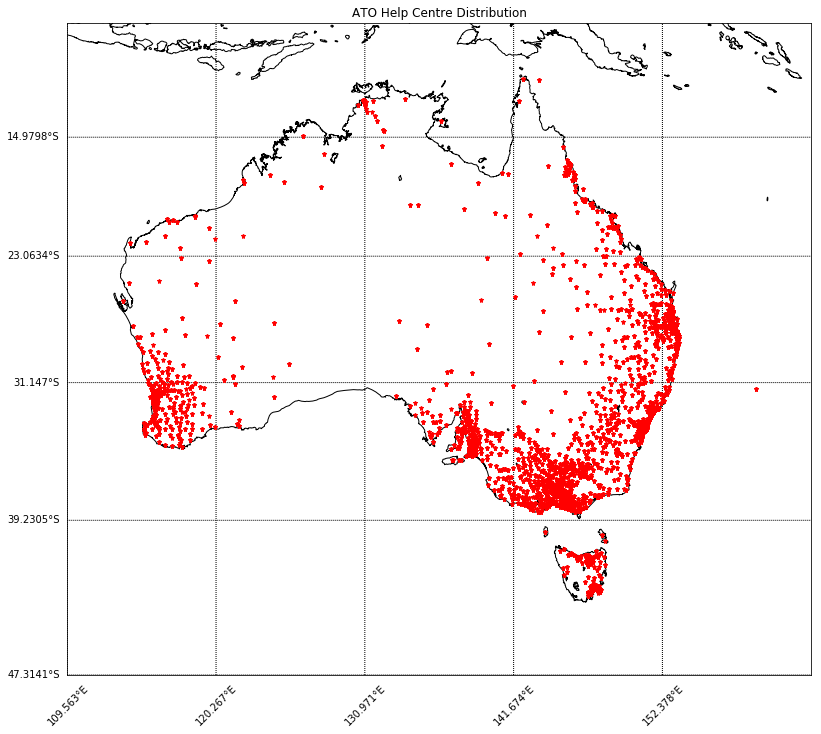

In [160]:
graph_data(lats,lons)

Save data to csv file:

[-47.314133, -6.8961778, 109.56335871428571, 163.08121699999998]


/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


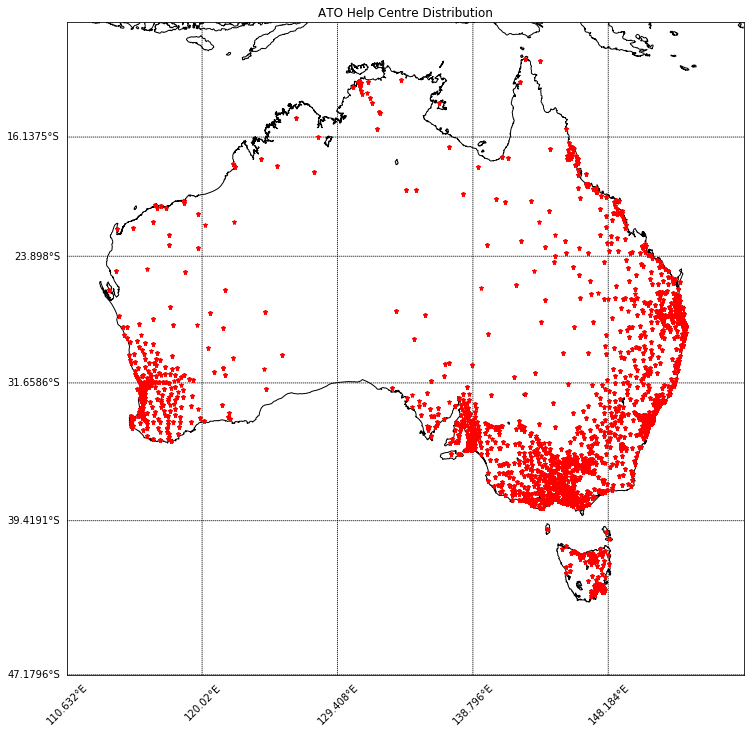

In [154]:
my_coords.to_csv('predicted.csv', sep=',', encoding='utf-8')